In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sqlalchemy import create_engine

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
# Set your local datbase parameters 
db_username = 'root'
db_password = 'mypassword'
host = '127.0.0.1'
port = '3306'
db_name = 'yelp_db'

# Create a MySQLEngine
engine = create_engine('mysql+mysqldb://'+db_username+':'+db_password+'@\
'+host+':'+port+'/'+db_name)

# Connect to database
engine.connect();

In [3]:
bid_stars = pd.read_sql(""" SELECT business_id, stars FROM review""", engine)

In [4]:
bid_stars['stars'].value_counts()

5    2253348
4    1223316
1     731363
3     615481
2     438161
Name: stars, dtype: int64

In [5]:
bid_stars_means = bid_stars.groupby('business_id').mean()

In [6]:
bid_stars_means.head()

,stars
business_id,
--6MefnULPED_I942VcFNA,3.135135
--7zmmkVg-IMGaXbuVd0SQ,3.851064
--8LPVSo5i0Oo61X01sV9A,4.333333
--9QQLMTbFzLJ_oT-ON3Xw,3.363636
--9e1ONYQuAa-CB_Rrw7Tw,4.088904


In [8]:
bid_stars_len = pd.read_sql(""" SELECT business_id, stars, length(text),useful,funny,cool FROM review""", engine)

In [9]:
bid_mean = bid_stars_len.groupby('business_id').mean()

In [10]:
bid_mean.head()

,stars,length(text),useful,funny,cool
business_id,,,,,
--6MefnULPED_I942VcFNA,3.135135,796.513514,1.351351,0.702703,0.864865
--7zmmkVg-IMGaXbuVd0SQ,3.851064,545.127660,1.574468,0.510638,1.000000
--8LPVSo5i0Oo61X01sV9A,4.333333,466.333333,3.000000,0.000000,0.000000
--9QQLMTbFzLJ_oT-ON3Xw,3.363636,471.363636,0.727273,0.272727,0.363636
--9e1ONYQuAa-CB_Rrw7Tw,4.088904,818.049621,1.070986,0.587870,0.712612


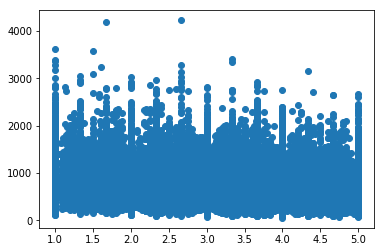

In [11]:
plt.scatter(bid_mean['stars'],bid_mean['length(text)'])

In [12]:
mean_len_star = bid_stars_len.groupby('stars').mean()

In [13]:
mean_len_star['length(text)']

stars
1    764.136689
2    769.220713
3    716.226290
4    631.459630
5    492.835890
Name: length(text), dtype: float64

In [14]:
users = pd.read_sql(""" SELECT id, review_count, average_stars, useful, funny, cool FROM user""", engine)

In [15]:
review_response = bid_stars_len.groupby('stars').sum()


In [16]:
review_response.head()

,length(text),useful,funny,cool
stars,,,,
1,558861301,1616952,517287,204448
2,337042517,712279,292800,182066
3,440823673,825371,378463,397658
4,772474669,1651213,694321,1008809
5,1110530768,2482043,796350,1290839


In [18]:
users.head()

,id,review_count,average_stars,useful,funny,cool
0,---1lKK3aKOuomHnwAkAow,246,3.96,67,22,9
1,---94vtJ_5o_nikEs6hUjg,2,5.00,0,0,0
2,---cu1hq55BP9DWVXXKHZg,57,3.79,34,14,0
3,---fhiwiwBYrvqhpXgcWDQ,8,2.78,2,3,1
4,---PLwSf5gKdIoVnyRHgBA,2,4.00,1,0,0


In [19]:
np.median(users['review_count'])
np.mean(users['review_count'])

23.11716151333873

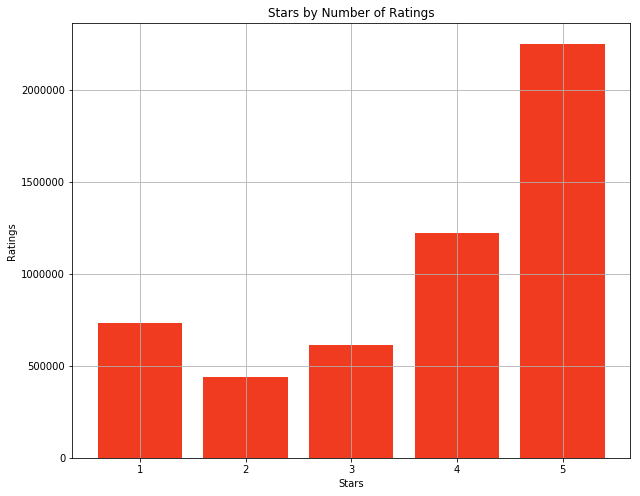

In [53]:
plt.bar(bid_stars['stars'].value_counts().index,bid_stars['stars'].value_counts(), color = '#f03b20')
plt.xlabel('Stars')
plt.ylabel('Ratings')
plt.title('Stars by Number of Ratings')
plt.grid()
plt.show();

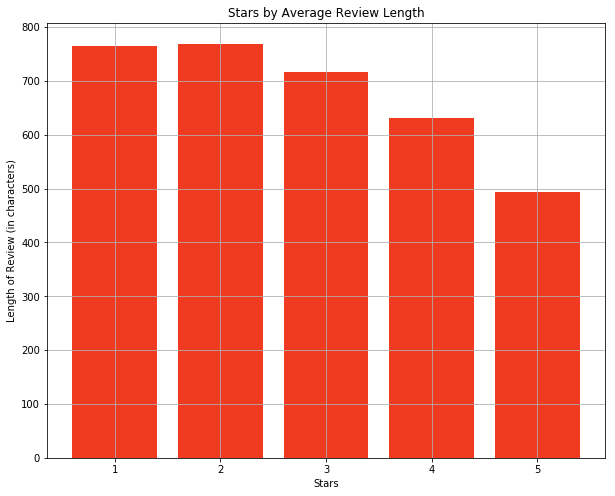

In [52]:
plt.bar(mean_len_star.index,mean_len_star['length(text)'], color = '#f03b20')
plt.xlabel('Stars')
plt.ylabel('Length of Review (in characters)')
plt.title('Stars by Average Review Length')
plt.grid()
plt.show();

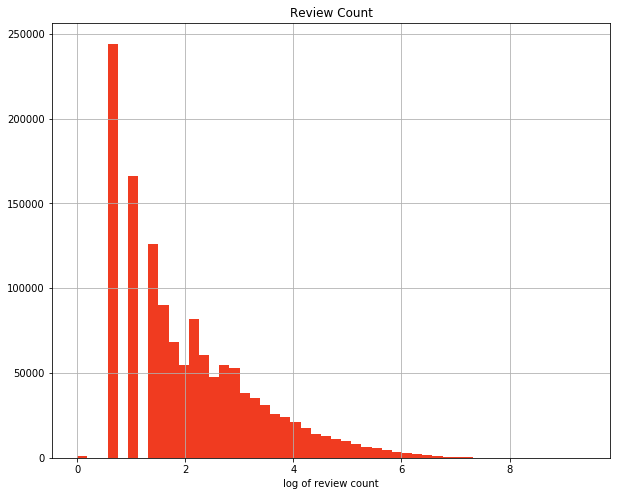

In [49]:
plt.hist(np.log(users['review_count']+1),bins = 50, color = '#f03b20');
plt.xlabel('log of review count')
plt.title('User Review Count')
plt.grid()
plt.show();

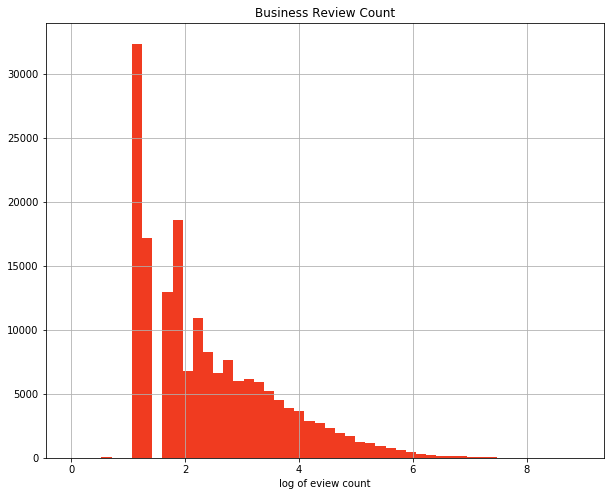

In [57]:
plt.hist(np.log(bid_stars_len['business_id'].value_counts()), bins = 50, color = '#f03b20')
plt.xlabel('log of eview count')
plt.title('Business Review Count')
plt.grid()
plt.show();

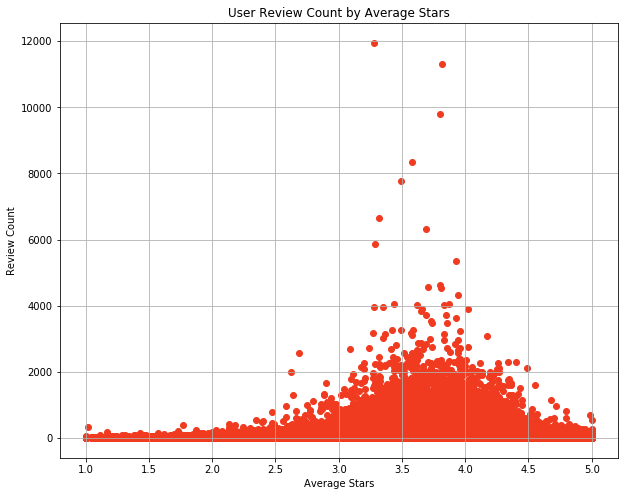

In [51]:
plt.scatter(users['average_stars'],users['review_count'], color = '#f03b20')
plt.xlabel('Average Stars')
plt.ylabel('Review Count')
plt.title('User Review Count by Average Stars')
plt.grid()
plt.show();

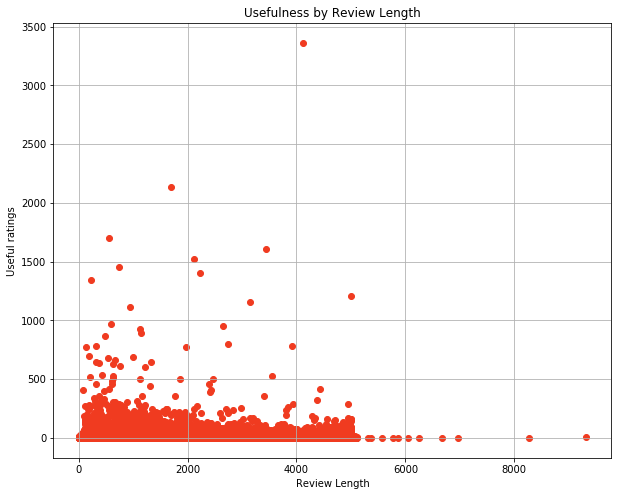

In [48]:
plt.scatter(bid_stars_len['length(text)'],bid_stars_len['useful'], color = '#f03b20')
plt.xlabel('Review Length')
plt.ylabel('Useful ratings')
plt.title('Usefulness by Review Length')
plt.grid()
plt.show();

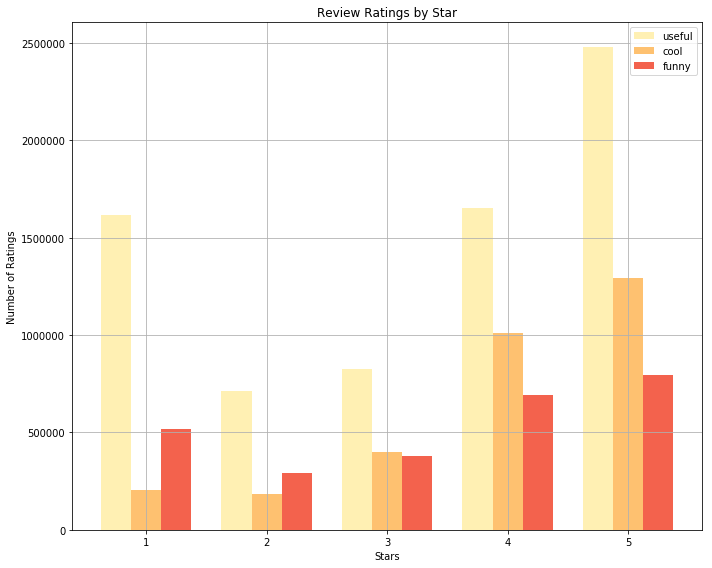

In [47]:
fig, ax = plt.subplots()
index = np.arange(5)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, review_response['useful'], bar_width,
                 alpha=opacity,
                 color='#ffeda0',
                 label='useful')
 
rects2 = plt.bar(index + bar_width, review_response['cool'], bar_width,
                 alpha=opacity,
                 color='#feb24c',
                 label='cool')

rects3 = plt.bar(index + bar_width*2, review_response['funny'], bar_width,
                 alpha=opacity,
                 color='#f03b20',
                 label='funny')

plt.xlabel('Stars')
plt.ylabel('Number of Ratings')
plt.title('Review Ratings by Star')
plt.xticks(index + bar_width, ('1', '2', '3', '4','5'))
plt.legend()
plt.grid()
 
plt.tight_layout()
plt.show()

## Making Predictions

### Parts of Speech Tagging

- First abstract parts of speech from reviews counting each occurrence
- Use category counts
- More generalizable across languages
- More interpretable results

In [14]:
import nltk

In [76]:
subX2 = subX.reset_index()
suby2 = suby.reset_index()

In [80]:
tokened = nltk.pos_tag(nltk.word_tokenize(subX2['text'][0]))

In [ ]:
pos_count = []
for i in range(len(subX2['text'])):
    tokened = nltk.pos_tag(nltk.word_tokenize(subX2['text'][i]))
    tags = [b[1] for b in tokened]
    fd = nltk.FreqDist(tags)
    pos_count.append(dict(fd))
    if i%5000==0:
        print(f'done {i}')

In [86]:
tagged = pd.DataFrame(pos_count)

In [89]:
tagged.columns

Index(['#', '$', '''', '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW',
       'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT',
       'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB',
       'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'],
      dtype='object')

In [92]:
tagged = tagged.drop(columns=['#', '$', '\'\'', '(', ')', ',', '.', ':','``'])

In [97]:
tagged = tagged.fillna(0)

In [62]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [63]:
nbmodel = MultinomialNB()
nbmodel.fit(train_tvectX, train_suby)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [64]:
nbmodel.score(test_tvectX, test_suby)

0.6253587243666495

In [133]:
import pickle
filename = 'nbmodel.sav'
pickle.dump(nbmodel, open(filename, 'wb'))

In [114]:
from sklearn.metrics import confusion_matrix
nbconfusion = confusion_matrix(test_suby, nbmodel.predict(test_tvectX))

In [67]:
import seaborn as sns

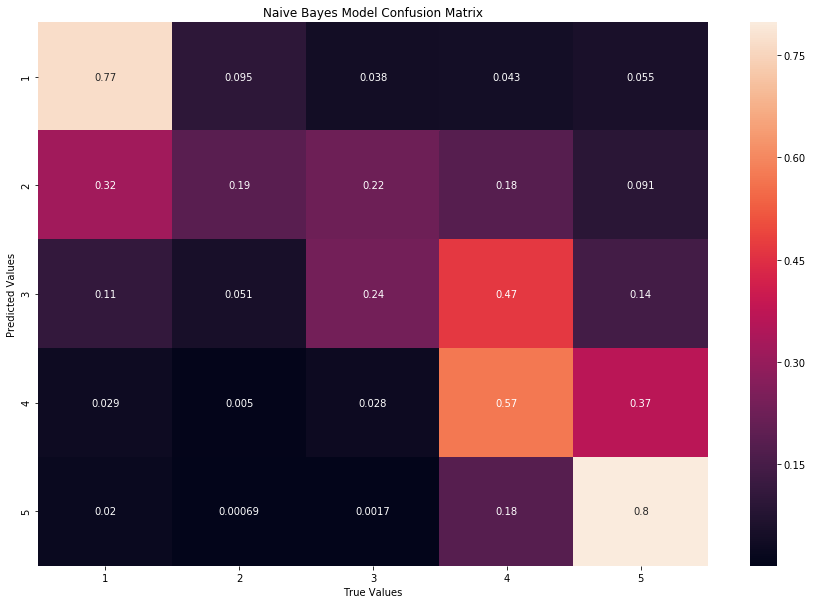

In [130]:
ax2 = sns.heatmap(nbconfusion/nbconfusion.sum(axis=1)[:, np.newaxis], 
            xticklabels=range(1,6), yticklabels=range(1,6),annot=True)
ax2.set(xlabel='True Values', ylabel='Predicted Values')
ax2.set_title('Naive Bayes Model Confusion Matrix');